In [15]:
# importing libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
dicionario_renomear_colunas = {
    "PM 2,5": "PM2.5",
    "Partículas Respiráveis (<2,5µm)(µg/m3)": "PM2.5",
    "Partículas Inaláveis (<10µm)(µg/m3)": "PM10",
    "Temperatura (ºC)": "Temperatura",
    "Tº": "Temperatura",
    "Radiação Solar (W/m2)": "Radiação Solar",
    "Monóxido de Carbono (ppm)": "Monóxido de Carbono",
    "CO": "Monóxido de Carbono",
    "Velocidade Escalar do Vento (m/s)": "Velocidade do Vento",
    "Direção Escalar do Vento (grau)": "Direção do Vento",
    "Umidade relativa (%)": "Umidade Relativa",
    "Precipitação Pluviométrica (mm)": "Precipitação",
    "Pressão Atmosférica (mmHg)": "Pressão Atmosférica",
    "Dióxido de enxofre (ppb)": "Dióxido de Enxofre",
    "Ozônio (ppb)": "Ozônio",
    "Monóxido de Nitrogênio (ppb)": "Monóxido de Nitrogênio",
    "Óxidos de Nitrogênio (ppb)": "Óxidos de Nitrogênio",
    "Dióxido de Nitrogênio (ppb)": "Dióxido de Nitrogênio",
    "HCT (ppm)": "HCT",
    "CH4 (ppm)": "Metano",
    "HCNM (ppm)": "HCNM",
    "Monóxido de Carbono Média Móvel (ppm)": "Monóxido de Carbono Média Móvel",
    "Data": "Data",
    "Hora": "Hora",
    "Média Horária": "Média Horária",
    "Seno da direção do vento": "Seno da Direção do Vento",
    "Cosseno da direção do vento": "Cosseno da Direção do Vento",
    "Seno ponderado": "Seno Ponderado",
    "Cosseno ponderado": "Cosseno Ponderado",
    "PM10": "PM10",
    "NO2": "Dióxido de Nitrogênio",
    "O3": "Ozônio",
    "SO2": "Dióxido de Enxofre",
    "DV": "Direção do Vento",
    "PP": "Pressão Atmosférica",
    "PA": "Precipitação",
    "VV": "Velocidade do Vento",
    "RS": "Radiação Solar",
    "UR": "Umidade Relativa"
}

In [17]:
import os
import pandas as pd
import numpy as np

pasta_principal = "data"
pastas_estacoes = [f for f in os.listdir(pasta_principal) if os.path.isdir(os.path.join(pasta_principal, f))]

def obter_skiprows(ano, estacao):
    if ano == 2021 and estacao == "Cascata":
        return [0, 1, 3]
    elif ano >= 2015:
        return [0, 2]
    else:
        return None

for pasta_estacao in reversed(pastas_estacoes):
    path = os.path.join(pasta_principal, pasta_estacao)
    dados = [f for f in os.listdir(path) if f.endswith(".xlsx")]
    
    for arquivo in dados:
        ano = int(arquivo.split("_")[1].split(".")[0])
        caminho_arquivo = os.path.join(path, arquivo)
        skiprows = obter_skiprows(ano, pasta_estacao)
        df = pd.read_excel(caminho_arquivo, skiprows=skiprows)
            
        if ano < 2015:
            df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y', errors='coerce')
            df['Hora'] = pd.to_datetime(df['Hora'], format='%H:%M:%S', errors='coerce').dt.time
            
            # Combinar 'Data' e 'Hora' em 'Data e Hora'
            df['Data e Hora'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Hora'].astype(str), errors='coerce')
            df = df.drop(columns=['Data', 'Hora'])
        else:
            df.rename(columns={df.columns[0]: 'Data e Hora'}, inplace=True)
            df['Data e Hora'] = pd.to_datetime(df['Data e Hora'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
        
        df = df[df['Data e Hora'].notna()]
        df.set_index('Data e Hora', inplace=True)
        
        colunas_validas = df.columns.intersection(dicionario_renomear_colunas.keys())
        df.rename(columns={col: dicionario_renomear_colunas[col] for col in colunas_validas}, inplace=True)
        
        df = df.dropna(axis=1, how='all')

        # Verificar a quantidade de dados ausentes de PM2.5
        df.replace('*', np.nan, inplace=True)
        df = df.infer_objects(copy=False)  # Adicionando essa linha para manter o comportamento antigo
        pm25_ausentes = df['PM2.5'].isna().sum()        
        
        total_pm25 = len(df)
        percentual_ausentes = pm25_ausentes / total_pm25
        print(f"Estação: {pasta_estacao}, Ano: {ano}, Dados ausentes de PM2.5: {pm25_ausentes}/{total_pm25} ({percentual_ausentes:.2%})")
        
        # Salvar o arquivo tratado em uma pasta separada
        pasta_tratada = os.path.join("dados_tratados", "separado", pasta_estacao)
        os.makedirs(pasta_tratada, exist_ok=True)
        caminho_arquivo_tratado = os.path.join(pasta_tratada, f"{pasta_estacao}_{ano}_tratado.csv")
        df.to_csv(caminho_arquivo_tratado)

    # Combinar os dados tratados de todos os anos para cada estação
    pasta_tratada = os.path.join("dados_tratados", "separado", pasta_estacao)
    arquivos_tratados = [f for f in os.listdir(pasta_tratada) if f.endswith("_tratado.csv")]

    dfs_tratados = []
    for arquivo_tratado in arquivos_tratados:
        caminho_arquivo_tratado = os.path.join(pasta_tratada, arquivo_tratado)
        df_tratado = pd.read_csv(caminho_arquivo_tratado, index_col='Data e Hora', parse_dates=True)
        dfs_tratados.append(df_tratado)

    dados_tratados_combinados = pd.concat(dfs_tratados, ignore_index=False, axis=0)
    dados_tratados_combinados.reset_index(inplace=True)
    
    pasta_combinada = os.path.join("dados_tratados", "combinado", pasta_estacao)
    os.makedirs(pasta_combinada, exist_ok=True)
    dados_tratados_combinados.to_csv(os.path.join(pasta_combinada, f"{pasta_estacao}_tratado_combinado.csv"), index=False)


Estação: Piratininga, Ano: 2009, Dados ausentes de PM2.5: 8760/8760 (100.00%)
Estação: Piratininga, Ano: 2010, Dados ausentes de PM2.5: 8760/8760 (100.00%)
Estação: Piratininga, Ano: 2011, Dados ausentes de PM2.5: 8760/8760 (100.00%)
Estação: Piratininga, Ano: 2012, Dados ausentes de PM2.5: 8784/8784 (100.00%)
Estação: Piratininga, Ano: 2013, Dados ausentes de PM2.5: 8760/8760 (100.00%)
Estação: Piratininga, Ano: 2014, Dados ausentes de PM2.5: 8760/8760 (100.00%)
Estação: Piratininga, Ano: 2015, Dados ausentes de PM2.5: 7635/8760 (87.16%)
Estação: Piratininga, Ano: 2016, Dados ausentes de PM2.5: 1248/8784 (14.21%)
Estação: Piratininga, Ano: 2017, Dados ausentes de PM2.5: 1313/8760 (14.99%)
Estação: Piratininga, Ano: 2018, Dados ausentes de PM2.5: 1299/8760 (14.83%)
Estação: Piratininga, Ano: 2019, Dados ausentes de PM2.5: 1316/8760 (15.02%)
Estação: Piratininga, Ano: 2020, Dados ausentes de PM2.5: 989/8784 (11.26%)
Estação: Piratininga, Ano: 2021, Dados ausentes de PM2.5: 564/8760 (6.4

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

treated_folder = "dados_tratados/separado"
station_folders = [f for f in os.listdir(treated_folder) if os.path.isdir(os.path.join(treated_folder, f))]

for station_folder in station_folders:
    print(f"Análise descritiva para a estação: {station_folder}\n")
    
    treated_files = [f for f in os.listdir(os.path.join(treated_folder, station_folder)) if f.endswith(".csv")]
    
    for treated_file in reversed(treated_files):
        print("-" * 100)
        print(f"Arquivo tratado: {treated_file}")
        year = int(treated_file.split("_")[1])
        treated_file_path = os.path.join(treated_folder, station_folder, treated_file)
        df = pd.read_csv(treated_file_path, parse_dates=['Data e Hora'])
        
        if 'PM2.5' in df.columns and year >= 2015:
            print(f"\nAno: {year}")
            
            # Estatísticas descritivas básicas
            pm25_stats = df['PM2.5'].describe()
            print("Estatísticas descritivas para PM2.5:")
            print(pm25_stats)
            
            # Correlação entre PM2.5 e outras variáveis
            pm25_corr = df.corr(method='pearson')['PM2.5'].sort_values(ascending=False)
            print("\nCorrelação entre PM2.5 e outras variáveis:")
            print(pm25_corr)
            
            # Gaussiana
            skew = df['PM2.5'].skew()
            kurtosis = df['PM2.5'].kurtosis()
            print(f"\nAssimetria (skewness): {skew:.2f}")
            print(f"Curtose (kurtosis): {kurtosis:.2f}")
            
            

Análise descritiva para a estação: Cascata

----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2022_tratado.csv

Ano: 2022
Estatísticas descritivas para PM2.5:
count    4799.000000
mean       14.221921
std        10.154195
min         1.000000
25%         8.000000
50%        12.000000
75%        18.000000
max       113.000000
Name: PM2.5, dtype: float64

Correlação entre PM2.5 e outras variáveis:
PM2.5                    1.000000
PM10                     0.676695
Monóxido de Carbono      0.515932
Dióxido de Nitrogênio    0.378340
Dióxido de Enxofre       0.138135
Direção do Vento         0.071486
Umidade Relativa         0.011973
Pressão Atmosférica     -0.065515
Radiação Solar          -0.139598
Temperatura             -0.146869
Ozônio                  -0.166538
Velocidade do Vento     -0.274821
Data e Hora             -0.326011
Name: PM2.5, dtype: float64

Assimetria (skewness): 2.27
Curtose (kurtosis): 10.07


Análise descritiva para a estação: Cascata

----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2022_tratado.csv


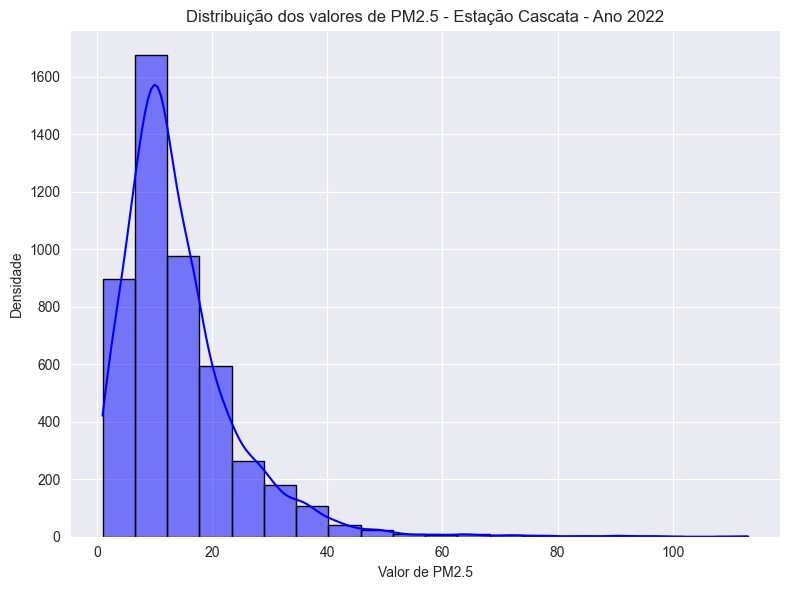


Possíveis outliers para PM2.5 (233 ocorrências):
2842    35.0
2921    36.0
2922    42.0
2924    50.0
2929    41.0
        ... 
6571    37.0
6619    34.0
6739    38.0
6740    41.0
6926    37.0
Name: PM2.5, Length: 233, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2021_tratado.csv


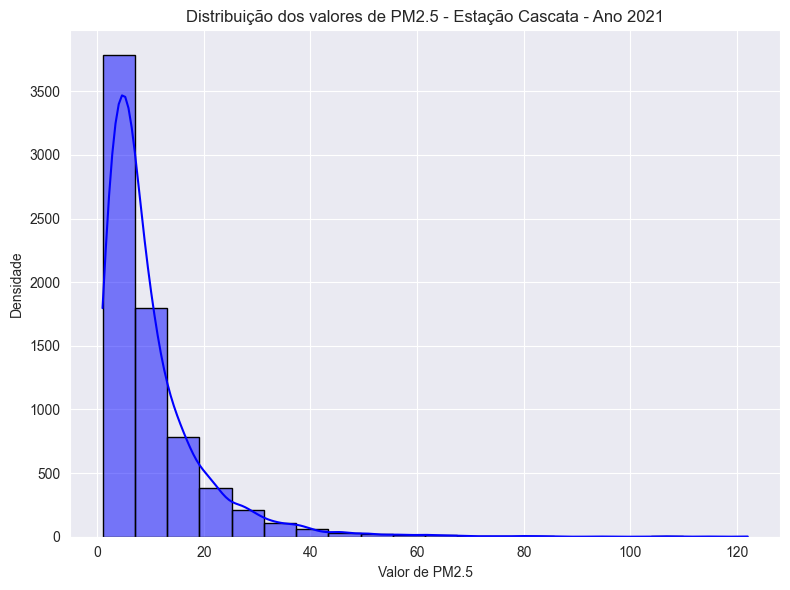


Possíveis outliers para PM2.5 (440 ocorrências):
0       27.0
458     49.0
466     38.0
631     28.0
1864    32.0
        ... 
6450    28.0
6522    35.0
6642    35.0
7846    27.0
8541    29.0
Name: PM2.5, Length: 440, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2020_tratado.csv


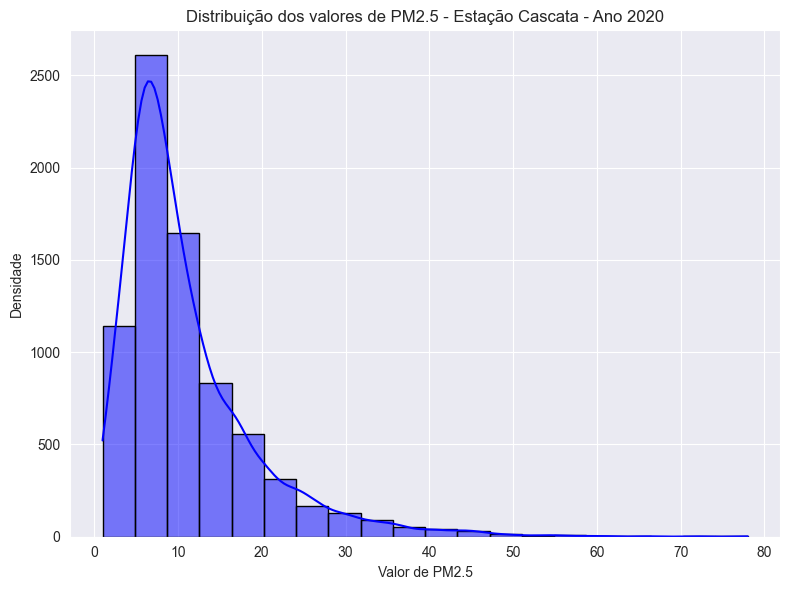


Possíveis outliers para PM2.5 (426 ocorrências):
262     32.0
263     29.0
264     29.0
265     30.0
266     29.0
        ... 
7680    35.0
8093    33.0
8094    28.0
8781    32.0
8782    38.0
Name: PM2.5, Length: 426, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2019_tratado.csv


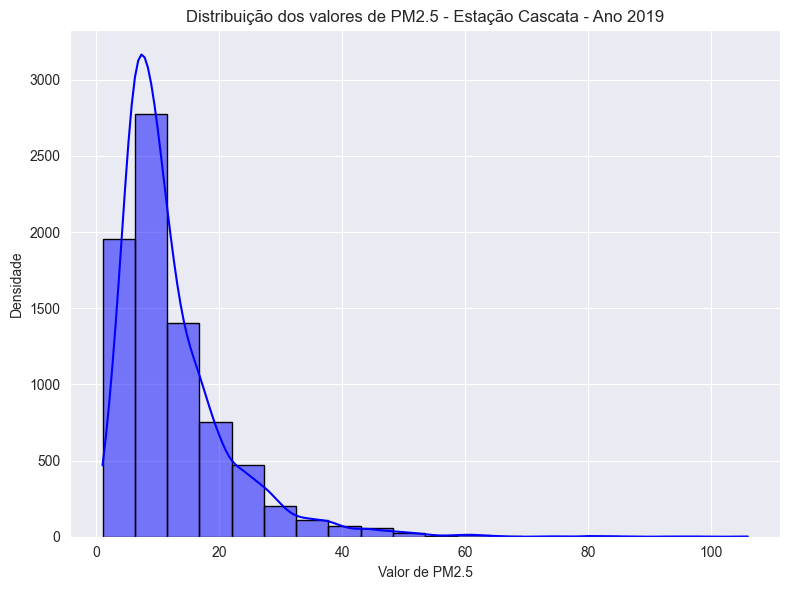


Possíveis outliers para PM2.5 (487 ocorrências):
0       33.0
162     29.0
284     28.0
521     29.0
525     29.0
        ... 
8590    47.0
8591    49.0
8592    58.0
8593    40.0
8594    29.0
Name: PM2.5, Length: 487, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2018_tratado.csv


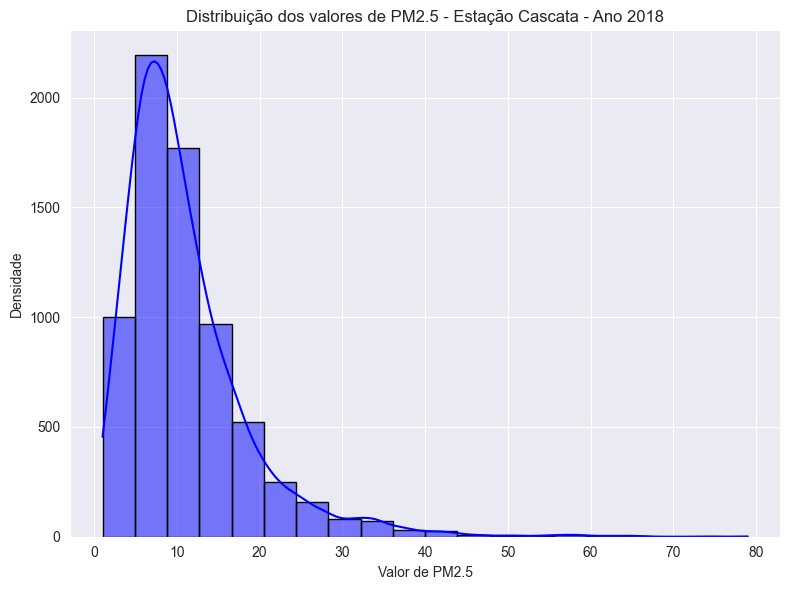


Possíveis outliers para PM2.5 (314 ocorrências):
427     32.0
476     27.0
620     57.0
643     43.0
1172    28.0
        ... 
8563    32.0
8564    41.0
8565    33.0
8566    32.0
8759    40.0
Name: PM2.5, Length: 314, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2017_tratado.csv


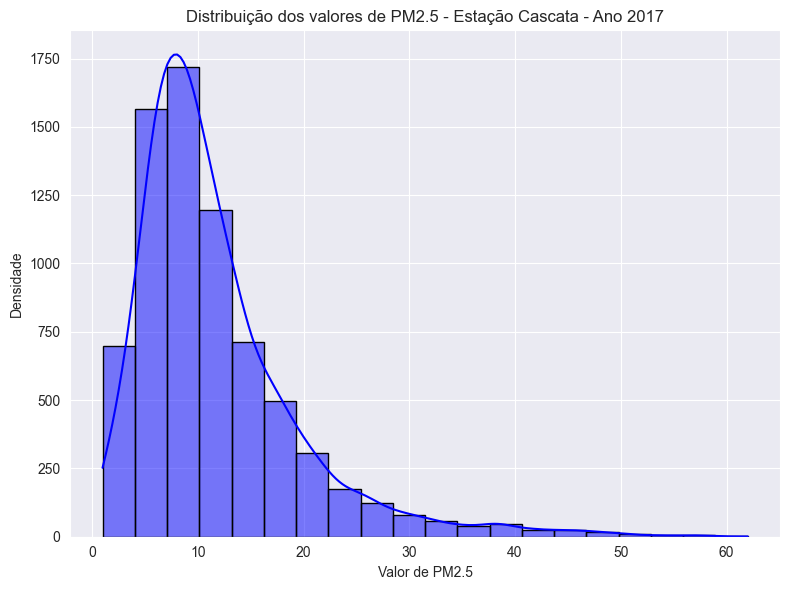


Possíveis outliers para PM2.5 (343 ocorrências):
228     46.0
229     32.0
249     30.0
619     44.0
905     29.0
        ... 
7222    29.0
7604    31.0
7956    28.0
8589    35.0
8758    29.0
Name: PM2.5, Length: 343, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2016_tratado.csv


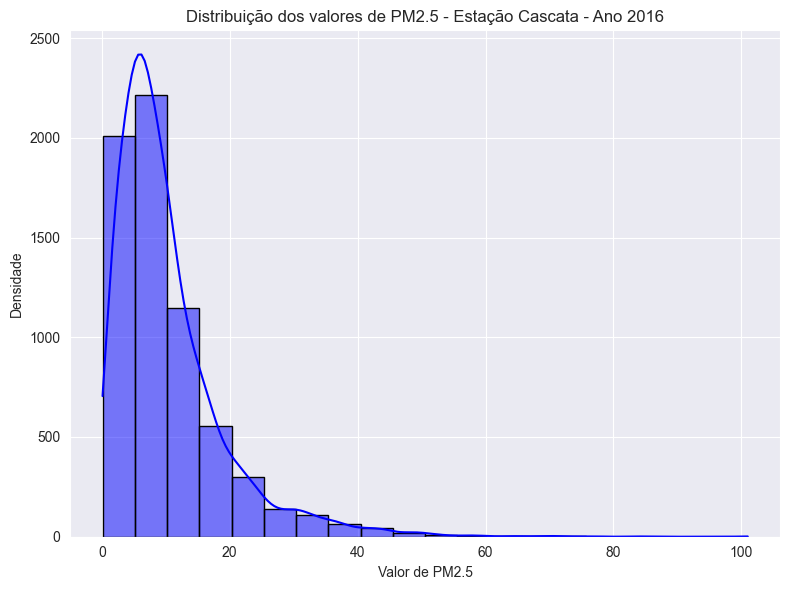


Possíveis outliers para PM2.5 (399 ocorrências):
0       43.0
1       34.0
2       32.0
4       32.0
787     29.0
        ... 
8180    29.0
8186    28.0
8189    31.0
8190    28.0
8192    26.0
Name: PM2.5, Length: 399, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2015_tratado.csv


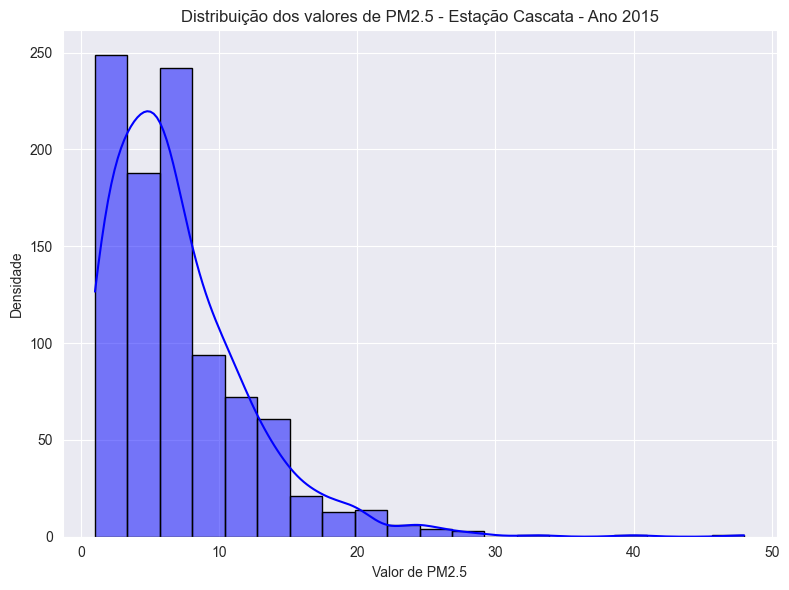


Possíveis outliers para PM2.5 (36 ocorrências):
7555    21.0
7566    24.0
7578    19.0
7580    28.0
7581    25.0
7582    24.0
7583    20.0
7585    24.0
7586    20.0
7587    19.0
7588    20.0
7589    27.0
7590    33.0
7627    20.0
7629    26.0
7630    25.0
7631    24.0
7651    19.0
7652    20.0
7758    20.0
7760    20.0
7779    20.0
7781    26.0
7797    19.0
7916    22.0
8228    20.0
8229    20.0
8416    19.0
8442    19.0
8614    20.0
8707    29.0
8723    21.0
8756    24.0
8757    23.0
8758    40.0
8759    48.0
Name: PM2.5, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2014_tratado.csv

Ano: 2014
A coluna 'PM2.5' não está presente nos dados.
----------------------------------------------------------------------------------------------------
Arquivo tratado: Cascata_2013_tratado.csv

Ano: 2013
A coluna 'PM2.5' não está presente nos dados.
-------------------------------------------------------

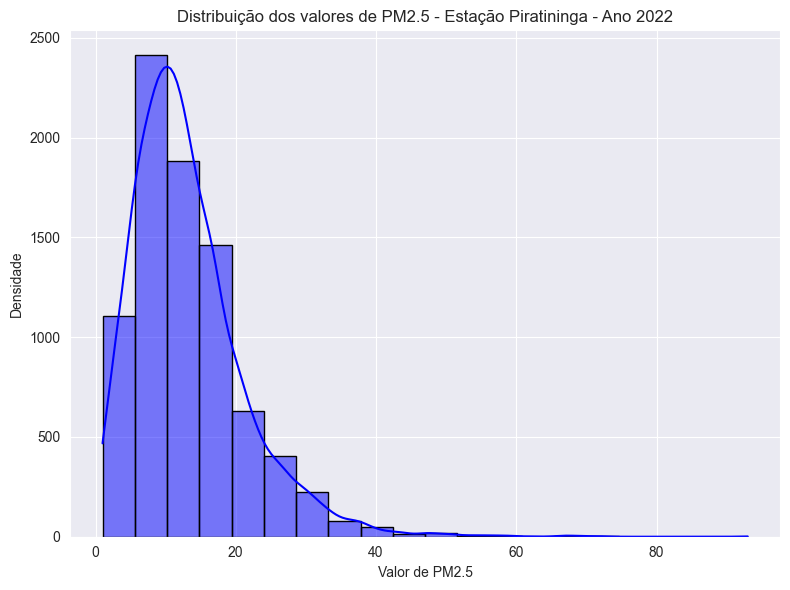


Possíveis outliers para PM2.5 (297 ocorrências):
129     33.0
139     39.0
160     37.0
253     41.0
666     37.0
        ... 
8201    40.0
8312    40.0
8313    44.0
8314    37.0
8394    50.0
Name: PM2.5, Length: 297, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2021_tratado.csv


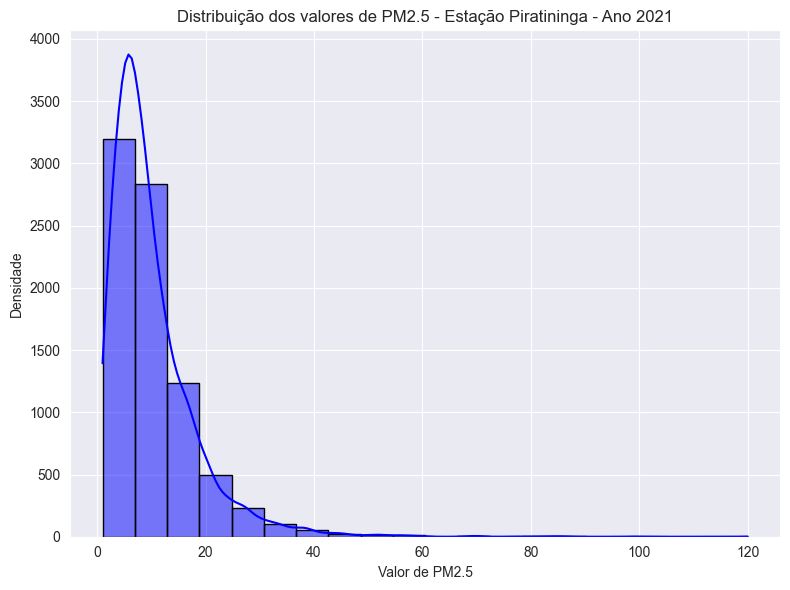


Possíveis outliers para PM2.5 (392 ocorrências):
352     33.0
353     45.0
487     38.0
738     48.0
827     28.0
        ... 
8317    30.0
8362    27.0
8403    38.0
8548    28.0
8680    40.0
Name: PM2.5, Length: 392, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2020_tratado.csv


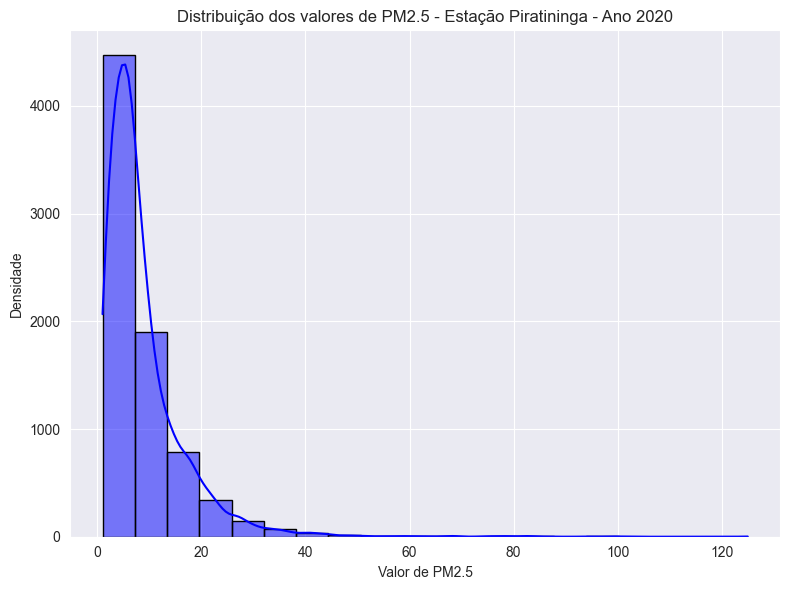


Possíveis outliers para PM2.5 (476 ocorrências):
47      36.0
56      36.0
203     22.0
301     27.0
324     23.0
        ... 
8435    41.0
8440    25.0
8480    25.0
8504    22.0
8536    41.0
Name: PM2.5, Length: 476, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2019_tratado.csv


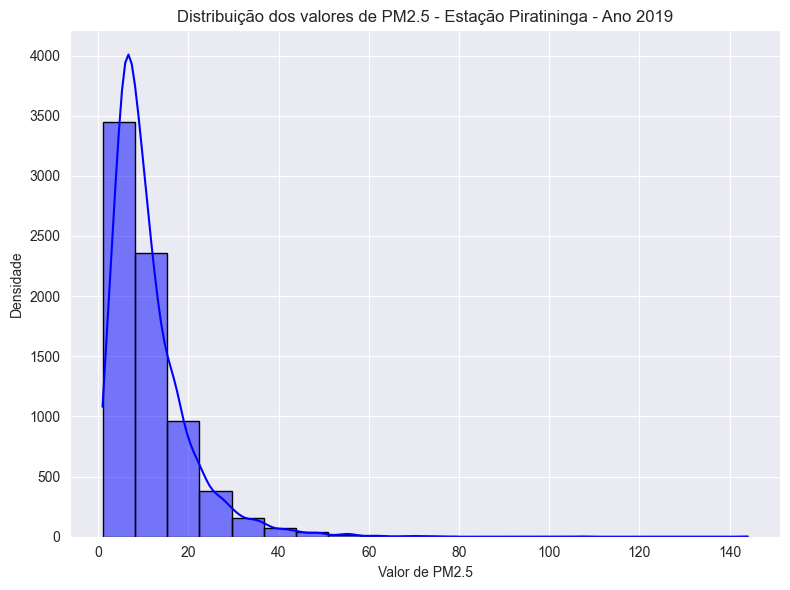


Possíveis outliers para PM2.5 (427 ocorrências):
0       37.0
56      29.0
57      52.0
58      31.0
61      56.0
        ... 
7545    35.0
7546    31.0
7552    31.0
8127    29.0
8283    54.0
Name: PM2.5, Length: 427, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2018_tratado.csv


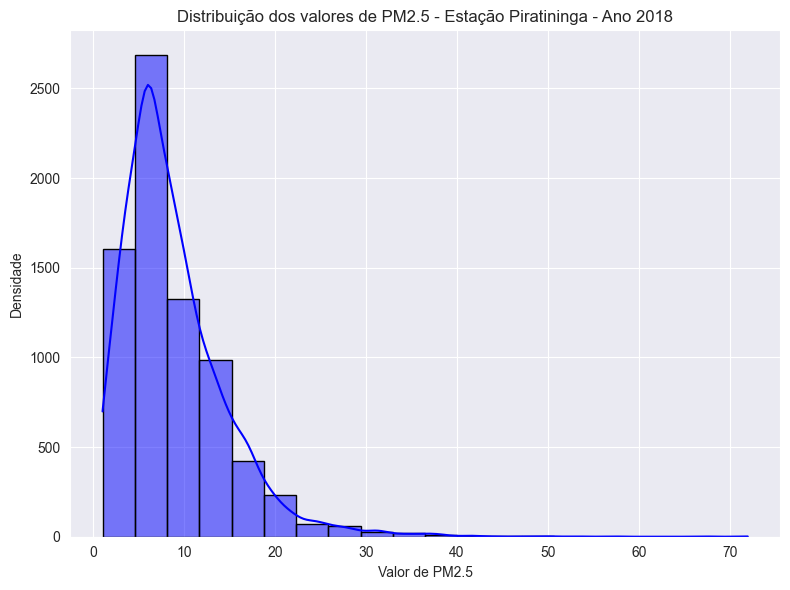


Possíveis outliers para PM2.5 (286 ocorrências):
426     21.0
677     22.0
685     22.0
704     21.0
1212    24.0
        ... 
8629    28.0
8677    31.0
8679    26.0
8680    22.0
8681    25.0
Name: PM2.5, Length: 286, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2017_tratado.csv


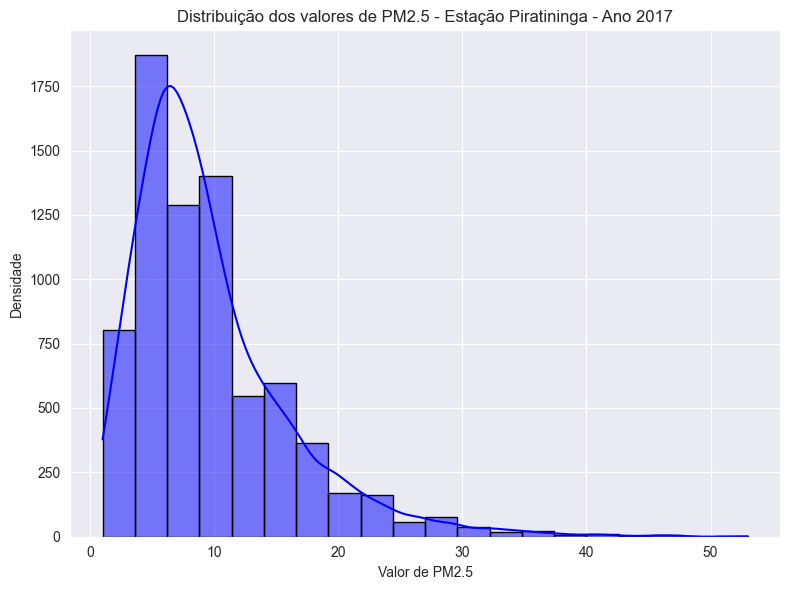


Possíveis outliers para PM2.5 (343 ocorrências):
178     30.0
296     24.0
754     42.0
779     29.0
809     25.0
        ... 
8329    37.0
8338    25.0
8720    23.0
8721    24.0
8759    27.0
Name: PM2.5, Length: 343, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2016_tratado.csv


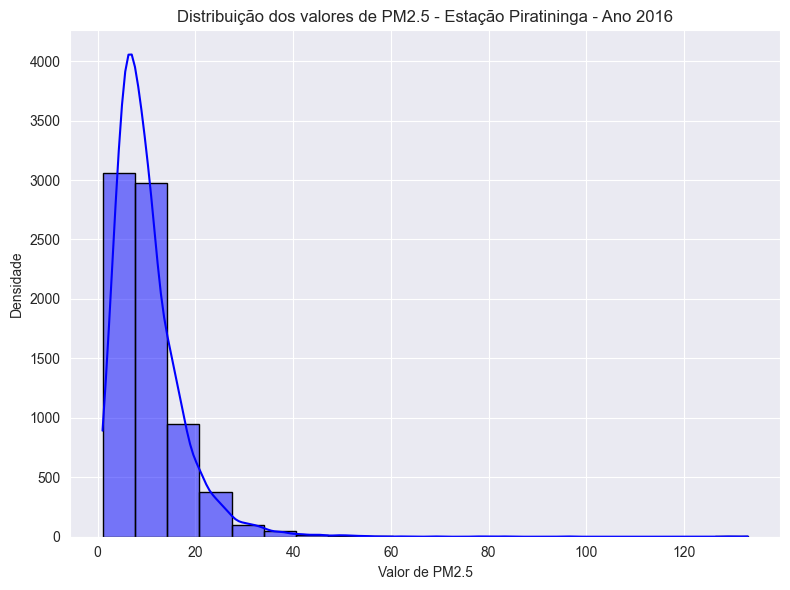


Possíveis outliers para PM2.5 (345 ocorrências):
0       34.0
1       25.0
5       26.0
280     25.0
344     27.0
        ... 
8186    28.0
8187    25.0
8191    27.0
8253    25.0
8313    27.0
Name: PM2.5, Length: 345, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2015_tratado.csv


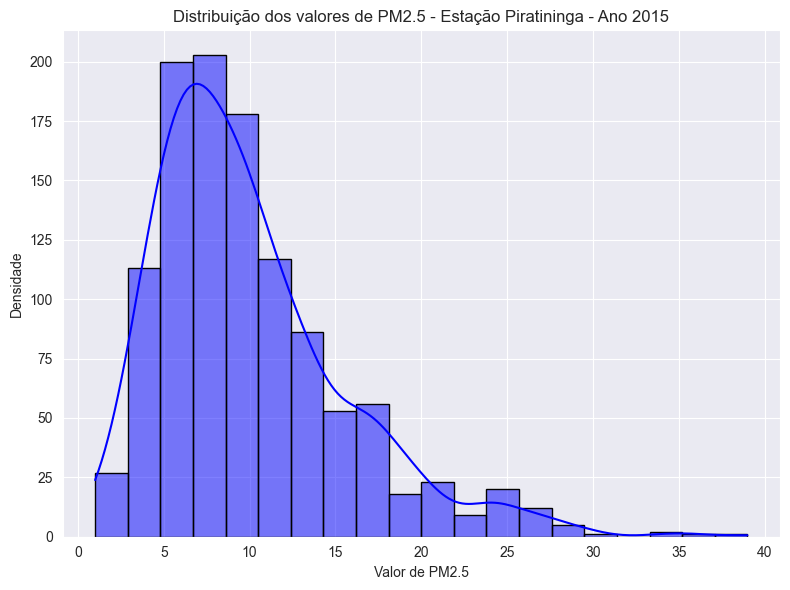


Possíveis outliers para PM2.5 (42 ocorrências):
7378    25.0
7392    24.0
7400    25.0
7401    24.0
7402    28.0
7403    27.0
7404    24.0
7409    26.0
7410    30.0
7428    27.0
7429    27.0
7430    24.0
7437    24.0
7579    25.0
7580    29.0
7581    26.0
7589    24.0
7604    27.0
7605    29.0
7666    29.0
7674    26.0
7760    24.0
7774    24.0
7779    24.0
7780    36.0
7781    35.0
7782    27.0
7839    25.0
8002    39.0
8003    27.0
8063    26.0
8119    24.0
8120    24.0
8169    24.0
8224    25.0
8226    27.0
8408    24.0
8416    29.0
8443    27.0
8444    25.0
8758    34.0
8759    24.0
Name: PM2.5, dtype: float64
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2014_tratado.csv

Ano: 2014
A coluna 'PM2.5' não está presente nos dados.
----------------------------------------------------------------------------------------------------
Arquivo tratado: Piratininga_2013_tratado.csv

Ano: 2013
A coluna 'PM2.5

In [19]:
import seaborn as sns

treated_folder = "dados_tratados/separado"
station_folders = [f for f in os.listdir(treated_folder) if os.path.isdir(os.path.join(treated_folder, f))]

for station_folder in station_folders:
    print(f"Análise descritiva para a estação: {station_folder}\n")

    treated_files = [f for f in os.listdir(os.path.join(treated_folder, station_folder)) if f.endswith(".csv")]

    for treated_file in reversed(treated_files):
        print("-" * 100)
        print(f"Arquivo tratado: {treated_file}")
        year = int(treated_file.split("_")[1])
        treated_file_path = os.path.join(treated_folder, station_folder, treated_file)
        df = pd.read_csv(treated_file_path, parse_dates=['Data e Hora'])

        if 'PM2.5' in df.columns and year >= 2015:
            # Verificar a distribuição dos valores de PM2.5 usando histograma
            # plt.figure(figsize=(8, 6))
            # plt.hist(df['PM2.5'], bins=20, edgecolor='black')
            # plt.xlabel('Valor de PM2.5')
            # plt.ylabel('Frequência')
            # plt.title(f'Distribuição dos valores de PM2.5 - Estação {station_folder} - Ano {year}')
            # plt.tight_layout()
            # plt.show()
            
            # Verificar a distribuição dos valores de PM2.5 usando gráfico de densidade
            plt.figure(figsize=(8, 6))
            sns.histplot(df, x='PM2.5', kde=True, bins=20, color='blue', edgecolor='black')
            plt.xlabel('Valor de PM2.5')
            plt.ylabel('Densidade')
            plt.title(f'Distribuição dos valores de PM2.5 - Estação {station_folder} - Ano {year}')
            plt.tight_layout()
            plt.show()
            
            # Identificar possíveis outliers
            q1 = df['PM2.5'].quantile(0.25)
            q3 = df['PM2.5'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)
            outliers = df[(df['PM2.5'] < lower_bound) | (df['PM2.5'] > upper_bound)]
            print(f"\nPossíveis outliers para PM2.5 ({len(outliers)} ocorrências):")
            print(outliers['PM2.5'])
        
        else:
            print(f"\nAno: {year}")
            print("A coluna 'PM2.5' não está presente nos dados.")
    
    print("\n" + "-" * 50)


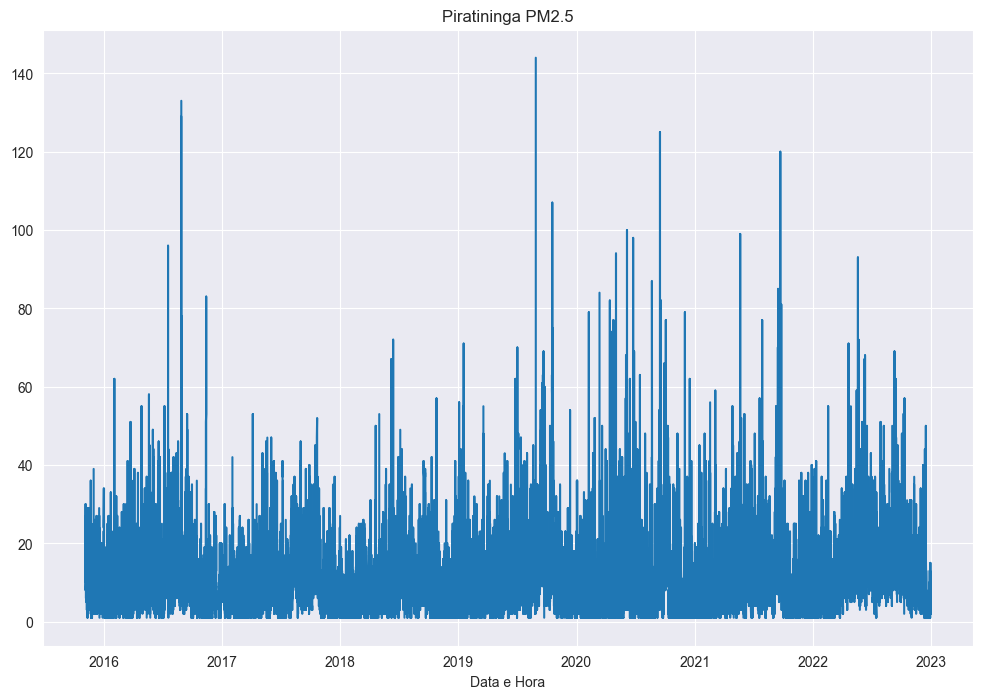

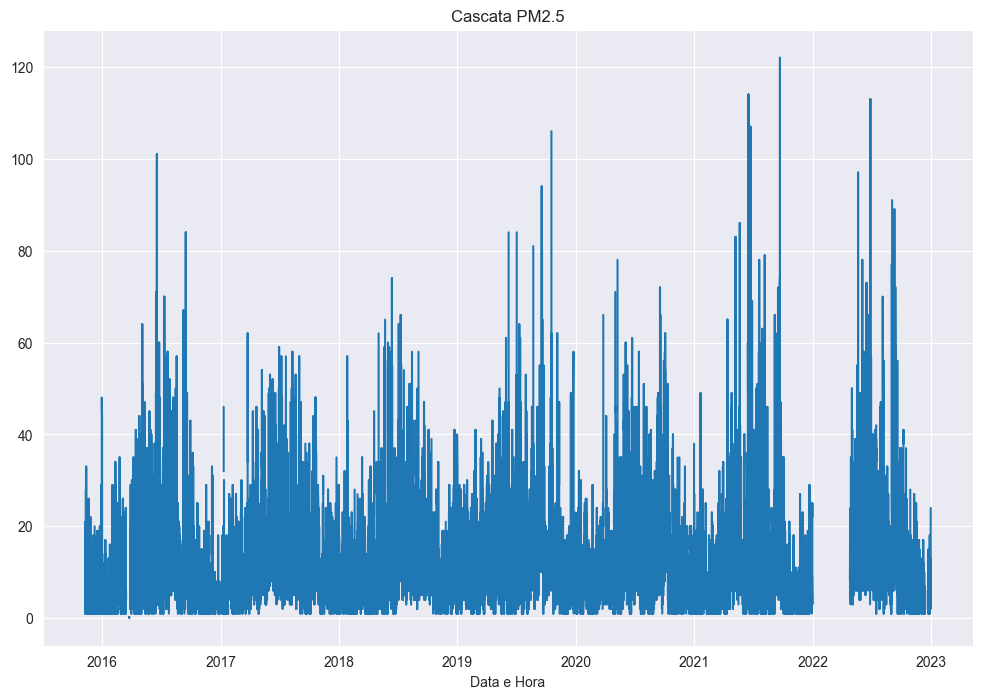

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# pega os nomes da estacoes
main_folder = "data"
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

#plota os graficos
for station_folder in reversed(station_folders):
    combined_data = pd.read_csv(f"dados_tratados/combinado/{station_folder}/{station_folder}_tratado_combinado.csv", usecols=['Data e Hora', 'PM2.5'])
    combined_data['Data e Hora'] = pd.to_datetime(combined_data['Data e Hora'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date
    combined_data = combined_data.set_index('Data e Hora')
    
    # Aumentando o tamanho do gráfico
    plt.figure(figsize=(12, 8))  
    
    combined_data['PM2.5'].plot()
    plt.title(f"{station_folder} PM2.5")
    plt.show()
